In [1]:
import sys
sys.path.append('..')

from bag_of_words import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

In [2]:
topic_num = 20
df = get_data(path='../data/iphone6.csv')

In [3]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                   max_features=200000,
                                   min_df=1,
                                   use_idf=True,
                                   ngram_range=(1,1),
                                   stop_words = 'english',
                                   norm='l2')
tfidf_matrix = tfidf_vectorizer.fit_transform(df.Reviews_bw)
vocab = tfidf_vectorizer.get_feature_names()

In [4]:
km = KMeans(n_clusters=topic_num)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
topics = km.labels_.tolist()
df['topics'] = topics
print df['topics'].value_counts()

12    2685
4     1857
11     861
18     501
14     434
5      419
10     397
19     326
0      325
7      293
15     237
9      211
2      187
3      171
1      166
13     151
16     126
17     111
6      107
8       91
Name: topics, dtype: int64


In [6]:
grouped = df['Rating'].groupby(df['topics'])
print grouped.mean()

topics
0     2.701538
1     4.066265
2     4.930481
3     4.643275
4     2.953150
5     4.651551
6     4.962617
7     4.877133
8     4.901099
9     4.947867
10    4.826196
11    2.770035
12    3.547858
13    4.774834
14    2.036866
15    4.962025
16    4.817460
17    4.495495
18    4.564870
19    4.693252
Name: Rating, dtype: float64


In [7]:
print "Top terms per cluster:"
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
review_group = df['Reviews'].groupby(df['topics'])

for i in range(topic_num):
    print "\nCluster %d words:" % i
    for ind in order_centroids[i, :5]: #replace 5 with n words per cluster
        print vocab[ind],

Top terms per cluster:

Cluster 0 words:
working stopped phone good months 
Cluster 1 words:
issues phone great new far 
Cluster 2 words:
perfect condition works phone conditions 
Cluster 3 words:
expected exactly works phone product 
Cluster 4 words:
phone great came got good 
Cluster 5 words:
good product far phone condition 
Cluster 6 words:
excelent product phone great seller 
Cluster 7 words:
great phone product price condition 
Cluster 8 words:
excelente producto recomendable product recomendado 
Cluster 9 words:
love phone iphone great new 
Cluster 10 words:
works great perfectly phone fine 
Cluster 11 words:
battery iphone phone charge life 
Cluster 12 words:
product good nice great described 
Cluster 13 words:
thank good phone great perfect 
Cluster 14 words:
work phone screen charger properly 
Cluster 15 words:
excellent product condition phone recommended 
Cluster 16 words:
thanks great good perfect excellent 
Cluster 17 words:
ok good phone product perfect 
Cluster 18 words

In [12]:
topic_names = {}
for i in range(topic_num):
    name = []
    for ind in order_centroids[i, :5]: #replace 5 with n words per cluster
        name.append(vocab[ind])
    topic_names[i] = ', '.join(name)

In [8]:
dist = 1 - cosine_similarity(tfidf_matrix)
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

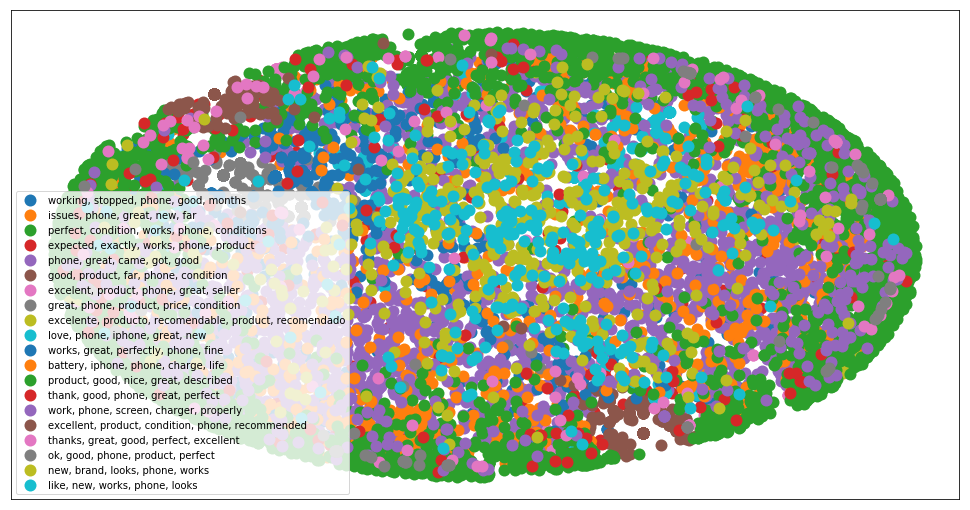

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
dfplot = pd.DataFrame(dict(x=xs, y=ys, label=topics, review=df["Reviews"])) 

#group by cluster
groups = dfplot.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=topic_names[name], #color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(dfplot.ix[i]['x'], dfplot.ix[i]['y'], dfplot.ix[i]['Review'], size=8)  

    
plt.show() #show the plot

In [15]:
plt.close()

In [18]:
import mpld3
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [23]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
dfplot = pd.DataFrame(dict(x=xs, y=ys, label=topics, review=df["Reviews"])) 

#group by cluster
groups = dfplot.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=topic_names[name], mec='none')
    ax.set_aspect('auto')
    labels = [i for i in group.review]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot